In [ ]:
import numpy as np
import os
import time
from matplotlib import pyplot as plt
from type_definitions.utils import *

In [2]:
seed = 100
save_plot = False
use_cached_distance_matrix = True  # Set to False to force recalculation
np.random.seed(seed)

In [3]:
print("Generating and evaluating test cases...")
cases = generate_cases(80)
results = evaluate_cases(cases)
trajectories = [r.trajectory for r in results if not r.simulation_failed]
valid_results = [r for r in results if not r.simulation_failed]

print(f"Generated {len(trajectories)} valid trajectories")
print(
    f"Crashed: {sum(1 for r in valid_results if r.crashed)}, Safe: {sum(1 for r in valid_results if not r.crashed)}"
)

Generating and evaluating test cases...
Generated 20 valid trajectories
Crashed: 6, Safe: 14


In [4]:
os.makedirs("cache", exist_ok=True)
distance_matrix_file = f"cache/distance_matrix_seed{seed}_size{len(trajectories)}.npy"

if use_cached_distance_matrix and os.path.exists(distance_matrix_file):
    print(f"Loading distance matrix from {distance_matrix_file}")
    distance_matrix = np.load(distance_matrix_file)
else:
    print("Calculating pairwise distances...")
    distance_matrix = pairwise_distances(trajectories)
    np.save(distance_matrix_file, distance_matrix)
    print(f"Distance matrix saved to {distance_matrix_file}")

print(f"Distance matrix shape: {distance_matrix.shape}")

Calculating pairwise distances...
Distance matrix saved to cache/distance_matrix_seed100_size20.npy
Distance matrix shape: (20, 20)


In [5]:
k_values = [3, 5, 7]
greedy_results = {}

print(f"Cluster statistics:")
for k in k_values:
    print(f"\n  k={k}:")
    start_time = time.time()

    center_indices, cluster_assignments = greedy_permutation_clustering(
        distance_matrix, k
    )

    end_time = time.time()

    unique_clusters = list(range(k))
    cluster_sizes = [cluster_assignments.count(i) for i in range(k)]

    cluster_stats = []
    for cluster_id in range(k):
        cluster_indices = [
            i for i, c in enumerate(cluster_assignments) if c == cluster_id
        ]
        cluster_results = [valid_results[i] for i in cluster_indices]
        crashed_count = sum(1 for r in cluster_results if r.crashed)
        total_count = len(cluster_results)
        crash_ratio = crashed_count / total_count if total_count > 0 else 0

        cluster_stats.append(
            {
                "cluster_id": cluster_id,
                "size": total_count,
                "crashed": crashed_count,
                "crash_ratio": crash_ratio,
            }
        )

    greedy_results[k] = {
        "center_indices": center_indices,
        "cluster_assignments": cluster_assignments,
        "cluster_stats": cluster_stats,
        "execution_time": end_time - start_time,
    }

    for stat in cluster_stats:
        print(
            f"    Cluster {stat['cluster_id']}: {stat['crashed']}/{stat['size']} crashed ({stat['crash_ratio']:.2%})"
        )

Cluster statistics:

  k=3:
    Cluster 0: 3/10 crashed (30.00%)
    Cluster 1: 1/4 crashed (25.00%)
    Cluster 2: 2/6 crashed (33.33%)

  k=5:
    Cluster 0: 3/10 crashed (30.00%)
    Cluster 1: 1/3 crashed (33.33%)
    Cluster 2: 0/3 crashed (0.00%)
    Cluster 3: 2/3 crashed (66.67%)
    Cluster 4: 0/1 crashed (0.00%)

  k=7:
    Cluster 0: 3/9 crashed (33.33%)
    Cluster 1: 0/2 crashed (0.00%)
    Cluster 2: 0/3 crashed (0.00%)
    Cluster 3: 2/3 crashed (66.67%)
    Cluster 4: 0/1 crashed (0.00%)
    Cluster 5: 1/1 crashed (100.00%)
    Cluster 6: 0/1 crashed (0.00%)


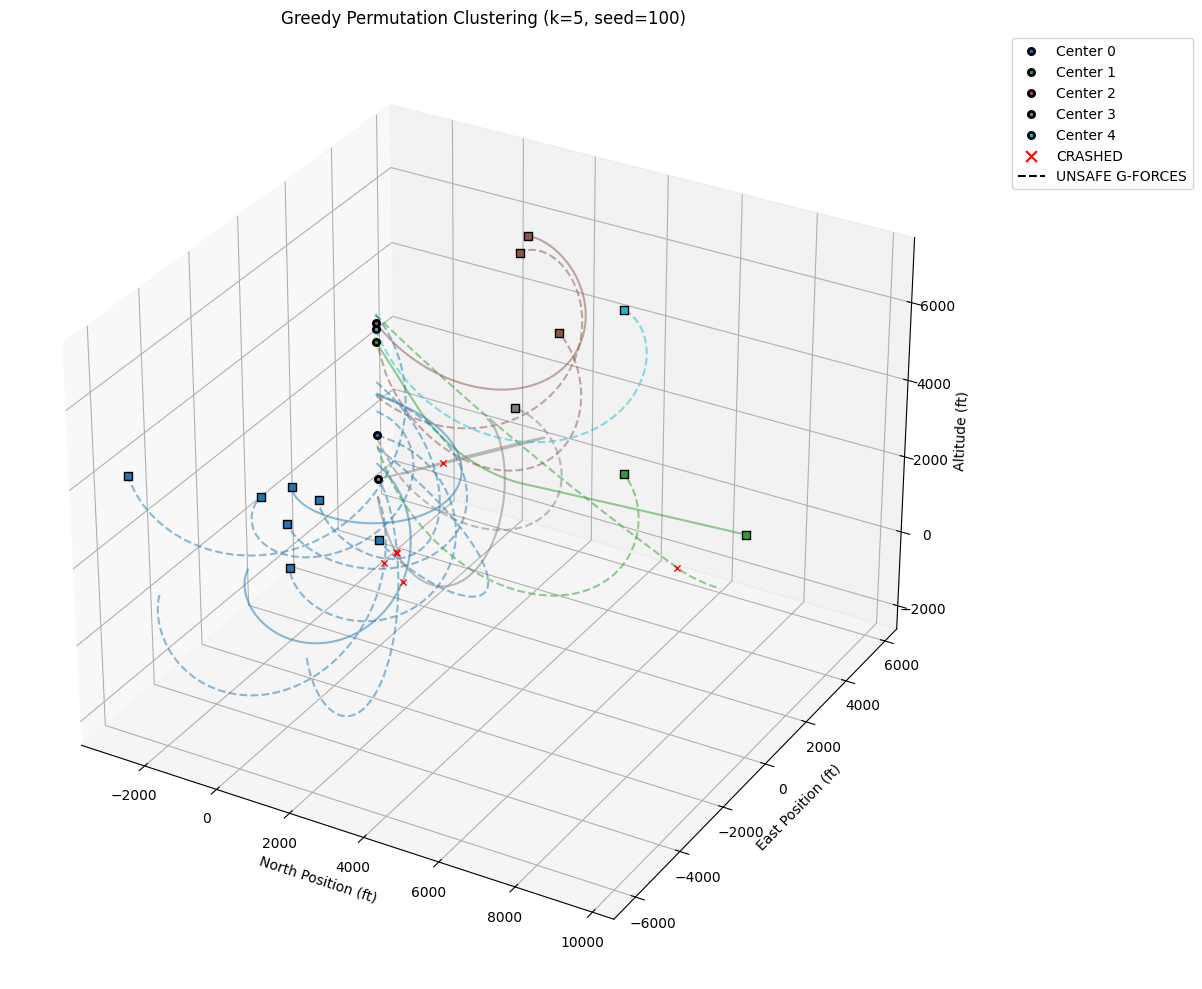

In [6]:
# 3D visualization
k = 5
if k in greedy_results:
    center_indices = greedy_results[k]["center_indices"]
    cluster_assignments = greedy_results[k]["cluster_assignments"]

    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection="3d")

    colors = plt.get_cmap("tab10")(np.linspace(0, 1, k))

    for i, (traj, cluster_id, result) in enumerate(
        zip(trajectories, cluster_assignments, valid_results)
    ):
        color = colors[cluster_id]

        # Check for unsafe g-forces
        has_unsafe_g = has_unsafe_gforces(traj)
        line_style = "--" if has_unsafe_g else "-"

        ax.plot(
            traj[:, 0],
            traj[:, 1],
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

        # Start point
        # ax.scatter(
        #     traj[0, 0],
        #     traj[0, 1],
        #     traj[0, 2],
        #     color=color,
        #     s=20,
        #     marker="o",
        #     edgecolor="black",
        #     linewidth=1,
        # )

        # End point
        if result.crashed:
            crash_idx = np.where(traj[:, 2] <= 0)[0]
            if len(crash_idx) > 0:
                crash_idx = crash_idx[0]
                ax.scatter(
                    traj[crash_idx, 0],
                    traj[crash_idx, 1],
                    traj[crash_idx, 2],
                    color="red",
                    s=20,
                    marker="x",
                    linewidth=1,
                )
        else:
            ax.scatter(
                traj[-1, 0],
                traj[-1, 1],
                traj[-1, 2],
                color=color,
                s=30,
                marker="s",
                edgecolor="black",
                linewidth=1,
            )

    for i, center_idx in enumerate(center_indices):
        center_traj = trajectories[center_idx]
        ax.scatter(
            center_traj[0, 0],
            center_traj[0, 1],
            center_traj[0, 2],
            color=colors[i],
            s=20,
            marker="o",
            edgecolor="black",
            linewidth=2,
            label=f"Center {i}",
        )

    if any(result.crashed for result in valid_results):
        ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

    # Add legend for unsafe g-forces
    if any(has_unsafe_gforces(traj) for traj in trajectories):
        ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

    ax.set_xlabel("North Position (ft)")
    ax.set_ylabel("East Position (ft)")
    ax.set_zlabel("Altitude (ft)")
    ax.set_title(f"Greedy Permutation Clustering (k={k}, seed={seed})")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    if save_plot:
        plt.savefig(f"results/{seed}_greedy_permutation_3d.png")
        print(f"Plot saved to results/{seed}_greedy_permutation_3d.png")

    plt.show()

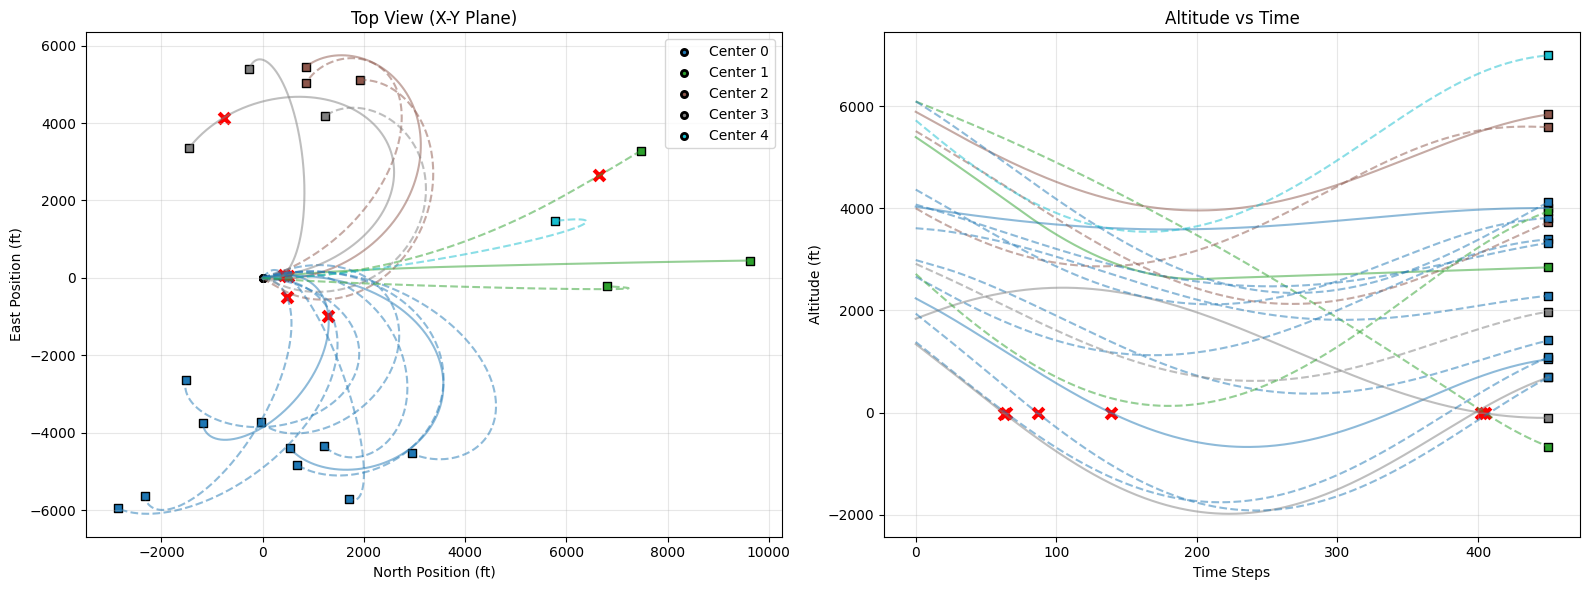

In [7]:
# 2D visualization
if k in greedy_results:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # X-Y plane
    ax1 = axes[0]
    for i, (traj, cluster_id, result) in enumerate(
        zip(trajectories, cluster_assignments, valid_results)
    ):
        color = colors[cluster_id]

        # Check for unsafe g-forces
        has_unsafe_g = has_unsafe_gforces(traj)
        line_style = "--" if has_unsafe_g else "-"

        if result.crashed:
            ax1.plot(
                traj[:, 0],
                traj[:, 1],
                color=color,
                alpha=0.5,
                linewidth=1.5,
                linestyle=line_style,
            )
            crash_idx = np.where(traj[:, 2] <= 0)[0]
            if len(crash_idx) > 0:
                crash_idx = crash_idx[0]
                ax1.scatter(
                    traj[crash_idx, 0],
                    traj[crash_idx, 1],
                    color="red",
                    s=60,
                    marker="x",
                    linewidth=3,
                )
        else:
            ax1.plot(
                traj[:, 0],
                traj[:, 1],
                color=color,
                alpha=0.5,
                linewidth=1.5,
                linestyle=line_style,
            )

        # ax1.scatter(
        #     traj[0, 0],
        #     traj[0, 1],
        #     color=color,
        #     s=20,
        #     marker="o",
        #     edgecolor="black",
        #     linewidth=1,
        # )
        ax1.scatter(
            traj[-1, 0],
            traj[-1, 1],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

    # Highlight centers
    for i, center_idx in enumerate(center_indices):
        center_traj = trajectories[center_idx]
        ax1.scatter(
            center_traj[0, 0],
            center_traj[0, 1],
            color=colors[i],
            s=20,
            marker="o",
            edgecolor="black",
            linewidth=2,
            label=f"Center {i}",
        )

    ax1.set_xlabel("North Position (ft)")
    ax1.set_ylabel("East Position (ft)")
    ax1.set_title("Top View (X-Y Plane)")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Altitude vs time
    ax2 = axes[1]
    for i, (traj, cluster_id, result) in enumerate(
        zip(trajectories, cluster_assignments, valid_results)
    ):
        color = colors[cluster_id]
        time_steps = np.arange(len(traj))

        # Check for unsafe g-forces
        has_unsafe_g = has_unsafe_gforces(traj)
        line_style = "--" if has_unsafe_g else "-"

        if result.crashed:
            ax2.plot(
                time_steps,
                traj[:, 2],
                color=color,
                alpha=0.5,
                linewidth=1.5,
                linestyle=line_style,
            )
            crash_idx = np.where(traj[:, 2] <= 0)[0]
            if len(crash_idx) > 0:
                crash_idx = crash_idx[0]
                ax2.scatter(
                    time_steps[crash_idx],
                    traj[crash_idx, 2],
                    color="red",
                    s=60,
                    marker="x",
                    linewidth=3,
                )
        else:
            ax2.plot(
                time_steps,
                traj[:, 2],
                color=color,
                alpha=0.5,
                linewidth=1.5,
                linestyle=line_style,
            )

        # ax2.scatter(
        #     0, traj[0, 2], color=color, s=20, marker="o", edgecolor="black", linewidth=1
        # )
        ax2.scatter(
            len(traj) - 1,
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

    ax2.set_xlabel("Time Steps")
    ax2.set_ylabel("Altitude (ft)")
    ax2.set_title("Altitude vs Time")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_plot:
        plt.savefig(f"results/{seed}_greedy_permutation_2d.png")
        print(f"2D plots saved to results/{seed}_greedy_permutation_2d.png")

    plt.show()